# Process Data

Convert the raw temperature data files into a form that the VAE model can accept as training data.

In [2]:
# import libraries

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Read Raw Data

In [3]:
df_list = []
for year in range(1974, 2024):
    ds = xr.open_dataset(f'data/raw/phoenix/t2m_{year}.nc')
    df = pd.DataFrame(index=ds['time'], data=ds['t2m'][:, 0, 0])
    df.index = pd.to_datetime(df.index)
    df_list.append(df)

df = pd.concat(df_list)
df.columns = ['Observed']

# convert Kelvin to Fahrenheit
df.Observed = (df.Observed - 273.15) * 9/5 + 32

df.describe()

,Observed
count,438288.000000
mean,73.367874
std,18.317912
min,21.952607
25%,58.228723
50%,73.569022
75%,88.170157
max,119.622822


## Time Zone Adjustment

Change from UTC to local time

In [4]:
df_mst = df.copy()
df_mst.index = df_mst.index.shift(-7, freq='h')
df_mst = df_mst.iloc[7:]
df_mst.head()

,Observed
1974-01-01 00:00:00,47.510187
1974-01-01 01:00:00,45.625235
1974-01-01 02:00:00,45.178172
1974-01-01 03:00:00,43.958910
1974-01-01 04:00:00,43.766911


## Climate Adjustment

The model I'm using requires the data to be stationary. So, I'm going to make a linear correction to the data to account for the upward trend of temperatures due to climate change. 

In [5]:
# Calculate the slope of the temperature trend across yearly averages

df_yearly = df_mst.resample('YS').mean()
slope = np.polyfit(df_yearly.index.year, df_yearly['Observed'], 1)[0]
slope

0.07298165298829348

A change in 0.7 degrees F per decade is quite high--about double the global temperature increase in recent years at about 0.35 degrees F per decade. However, this isn't shocking since different parts of the world are warming at different rates. This map produced by NOAA shows the temperature trend since 1994 (bottom plot), and, just eye-balling it, Arizona looks pretty close to 0.7 degrees per decade.

![images/global-surface-temperature-trends-map_1901-2023_and_1994-2023_1400px_alt02.jpg](images/global-surface-temperature-trends-map_1901-2023_and_1994-2023_1400px_alt02.jpg)



In [6]:
# Add climate adjusted data to dataframe

df_mst['Climate Adjusted'] = df_mst['Observed'] - 0.07 * (df_mst.index.year - 2024)
df_mst.describe()

,Observed,Climate Adjusted
count,438281.000000,438281.000000
mean,73.368176,75.083226
std,18.317895,18.287642
min,21.952607,24.262607
25%,58.229236,59.993846
50%,73.569382,75.281794
75%,88.170412,89.848373
max,119.622822,121.932822


### Plot Long-Term Trend

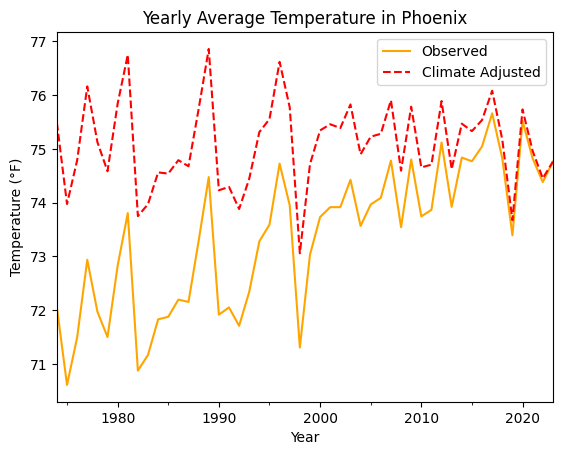

In [7]:
df_yearly = df_mst.resample('YS').mean()
df_yearly.plot()
plt.title('Yearly Average Temperature in Phoenix')
plt.ylabel('Temperature (°F)')
plt.xlabel('Year')
plt.gca().get_lines()[1].set_linestyle('--')

# set the color of both lines to orange
plt.gca().get_lines()[0].set_color('orange')
plt.gca().get_lines()[1].set_color('red')

plt.legend()
plt.savefig('images/long_term_trend.png')
plt.show()

In [8]:
df_mst.to_csv('data/processed/observed_time_series.csv')

## Standardize Data

Apply scale and offset so data has a mean of zero and standard deviation of one.

In [139]:
offset = round(df_mst['Climate Adjusted'].mean(), 2)
print('offset: ', offset)
scale = round(df_mst['Climate Adjusted'].std(), 2)
print('scale:  ', scale)
dft = (df_mst['Climate Adjusted'] - offset) / scale
dft.describe()

offset:  75.08
scale:   18.29


count    438281.000000
mean          0.000176
std           0.999871
min          -2.778425
25%          -0.824831
50%           0.011033
75%           0.807456
max           2.561663
Name: Climate Adjusted, dtype: float64

## Export Data

Make final preparations for data before it is fed into VAE model. 

In [141]:
# reshape dataframe to have 64*24 columns

k = 64*24
n = dft.shape[0] // k

data = dft.iloc[:n*k].values.reshape(n, k)
index = dft.index[:-k:k]

dft_reshaped = pd.DataFrame(data=data, index=index)

np.random.seed(42)
# shuffle rows
dft_reshaped = dft_reshaped.sample(frac=1)
dft_reshaped.to_csv('data/processed/phoenix_64days.csv')

dft_reshaped

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
1975-07-31,0.964283,0.758682,0.677235,0.667352,0.664610,0.607691,0.600477,0.801750,1.029786,1.009659,...,1.320080,1.315175,1.319647,1.315680,1.320585,0.886659,0.720375,0.695270,0.405120,0.365732
2017-08-19,0.703717,0.624205,0.521373,0.234700,0.337318,0.317850,0.227569,0.316138,0.638538,0.848409,...,0.345234,0.439151,0.485718,0.474878,0.369622,0.182857,0.012565,-0.023234,-0.123142,-0.315327
2001-07-06,0.839117,0.792497,0.617997,0.504204,0.451051,0.428592,0.352912,0.317114,0.430974,0.341955,...,1.397530,1.493560,1.484917,1.475048,1.471033,1.442517,0.777592,0.770106,0.652979,0.604590
2010-08-16,1.240002,1.121574,0.926427,0.802889,0.745228,0.727412,0.694128,0.678177,0.874774,0.905918,...,0.542830,0.585644,0.596969,0.592411,0.527708,0.450505,0.173873,0.086105,0.030448,-0.082456
1987-02-22,-1.260056,-1.367588,-1.481018,-1.603712,-1.679799,-1.740936,-1.751113,-1.717562,-1.681764,-1.422338,...,1.220573,1.273707,1.275041,1.271531,1.321508,1.103985,0.782790,0.710072,0.526452,0.478230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-11,-1.041151,-1.114603,-1.207998,-1.491556,-1.553934,-1.626629,-1.624703,-1.664318,-1.511225,-1.323540,...,-0.347897,-0.262600,-0.278471,-0.271025,-0.301563,-0.449291,-0.787470,-0.864418,-0.977245,-1.024708
1986-06-11,0.594550,0.479838,0.578058,0.037281,0.049013,0.052298,0.092726,0.322419,0.608160,0.908048,...,1.630983,1.819980,1.831177,1.671009,1.470882,1.320167,1.211221,1.204450,1.112331,1.030068
1992-07-29,0.912226,0.799497,0.679402,0.623579,0.602223,0.649598,0.627093,0.768274,0.969063,1.039755,...,1.437210,1.436331,1.436737,1.391794,1.193303,0.664128,0.388931,0.401096,0.255995,0.245182
2021-04-24,-0.149637,-0.277243,-0.380983,-0.462618,-0.562222,-0.645824,-0.717425,-0.609413,-0.270531,0.006312,...,1.681876,1.736526,1.729271,1.759037,1.746629,1.683300,1.499417,1.391677,1.277088,1.138498
